# Linear regression

In this lesson we will learn how to perform a simple linear regression by examining the counts, weight, and size measurements of juvenile snowshoe hares (*Lepus americanus*) observed at the Bonanza Creek Experimental Forest from 1999 to 2012 @kielland_snowshoe_2017. 

## About the data

Size measurements, sex, and age of snowshoe hares were collected and made available by Dr. Knut Kielland and colleagues at the [Bonanza Creek Experimental Forest Long Term Ecological Research (LTER) site](https://www.lter.uaf.edu) located approximately 20 km southwest of Fairbanks, Alaska, USA. The data contains observations of 3380 snowshoe hares obtained by capture-recapture studies conducted yearly from 1999 to 2012 in three sampling sites: Bonanza Riparian, Bonanza Mature and Bonanza Black Spruce. 

## Data exploration

Let's start by loading the data and taking a very high-level look at it:


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

In [2]:
hares= pd.read_csv(os.path.join('data','knb-lter-bnz','55_Hare_Data_2012.txt'))
hares.head()

,date,time,grid,trap,l_ear,r_ear,sex,age,weight,hindft,notes,b_key,session_id,study
0,11/26/1998,NaN,bonrip,1A,414D096A08,NaN,NaN,NaN,1370.0,160.0,NaN,917.0,51,Population
1,11/26/1998,NaN,bonrip,2C,414D320671,NaN,M,NaN,1430.0,NaN,NaN,936.0,51,Population
2,11/26/1998,NaN,bonrip,2D,414D103E3A,NaN,M,NaN,1430.0,NaN,NaN,921.0,51,Population
3,11/26/1998,NaN,bonrip,2E,414D262D43,NaN,NaN,NaN,1490.0,135.0,NaN,931.0,51,Population
4,11/26/1998,NaN,bonrip,3B,414D2B4B58,NaN,NaN,NaN,1710.0,150.0,NaN,933.0,51,Population


## Examining hares age data

In this example we are interested in working with data from juvenile hares exclusively. So we will:

1. Examine the values in the `age` column
2. Filter for observations in which age is 'adult' or 'juvenile'
3. Investigate the age distributions across time

From the [dataset's metadata](https://portal.edirepository.org/nis/metadataviewer?packageid=knb-lter-bnz.55.22) we know there are three allowedd values in the `age` column: 

- 'a' for 'adult', 
- 'j' for 'juvenile', and 
- 'm' for 'mortality'. 

In [6]:
# Examine the unique values in the age column
pd.DataFrame(hares['age'].value_counts(dropna=False))

,count
age,
NaN,2111
A,564
J,267
a,183
j,128
1/2/2013,21
1/4/2013,21
3/4/2013,18
1,12


In [7]:
# Update age values to juvenile and adult observations where 'a' and 'j' are included
hares.loc[hares.age.str.contains('j', case = False, na=False), 'age'] = 'juvenile'
hares.loc[hares.age.str.contains('a', case = False, na=False), 'age'] = 'adult'

In [8]:
# Examine the unique values in the age column
pd.DataFrame(hares['age'].value_counts(dropna=False))

,count
age,
NaN,2111
adult,759
juvenile,396
1/2/2013,21
1/4/2013,21
3/4/2013,18
1,12
U,11
?,10


In [9]:
hares.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3380 entries, 0 to 3379
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        3380 non-null   object 
 1   time        264 non-null    object 
 2   grid        3380 non-null   object 
 3   trap        3368 non-null   object 
 4   l_ear       3332 non-null   object 
 5   r_ear       3211 non-null   object 
 6   sex         3028 non-null   object 
 7   age         1269 non-null   object 
 8   weight      2845 non-null   float64
 9   hindft      1633 non-null   float64
 10  notes       243 non-null    object 
 11  b_key       3333 non-null   float64
 12  session_id  3380 non-null   int64  
 13  study       3217 non-null   object 
dtypes: float64(3), int64(1), object(10)
memory usage: 369.8+ KB


In [11]:
# Update date column to date-time 
hares['date'] = pd.to_datetime(hares['date'])
print(hares.date.dtype)

datetime64[ns]


In [12]:
hares_juv_adult = hares[hares.age.isin(['juvenile', 'adult'])].copy()
print(f"Number of selected juveniles and adult hares: {len(hares_juv_adult)}")

Number of selected juveniles and adult hares: 1155


Distribution of hare ages across years

In [13]:
# Extract year in which each observation happened
hares_juv_adult['year'] = hares_juv_adult.date.dt.year

In [18]:
# Create hares/year dataframe
hares_per_year = (hares_juv_adult.groupby(['year', 'age']).size()
                .reset_index(name = 'counts')
                .pivot(index = 'year', columns = 'age', values='counts'))

hares_per_year

age,adult,juvenile
year,,
1999,150.0,126.0
2000,159.0,67.0
2001,72.0,22.0
2002,3.0,NaN
2003,1.0,18.0
2004,NaN,8.0
2005,95.0,48.0
2006,101.0,15.0
2007,13.0,5.0


<Axes: xlabel='year'>

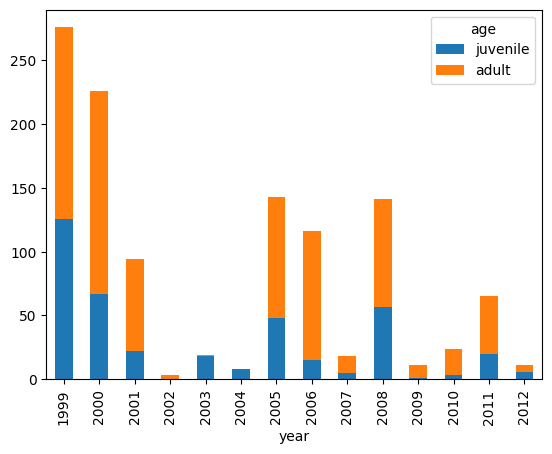

In [19]:
hares_per_year[['juvenile', 'adult']].plot(kind = 'bar', stacked = True)

## Select juvenile hares and width/hind foot measurements

Number of juvenile hares with hind toot and weight measurements: 265


<Axes: xlabel='hindft', ylabel='weight'>

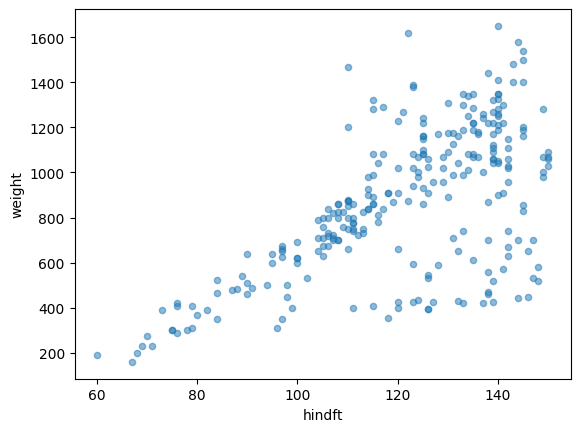

In [21]:
# Subset juvenile hares with hind foot and weight measurements
juveniles_weight_hindft = hares_juv_adult[(hares_juv_adult['hindft'].notna()) &
                                          (hares_juv_adult['weight'].notna()) &
                                          (hares_juv_adult['age']== 'juvenile')]

juveniles_weight_hindft

print(f"Number of juvenile hares with hind toot and weight measurements: {len(juveniles_weight_hindft)}")
juveniles_weight_hindft.plot.scatter(x = 'hindft', y = 'weight', alpha =0.5)

## Linear regression

For our analysis we want to investigate possible relations between hind foot length and weight for juvenile hares.

Let's investigate whether a linear model is an adequate way to describe this data. To do this we will use the [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model from the [`scikit-learn`](https://scikit-learn.org/stable/index.html) library. 


The trickiest part of fiting the model is to get the data in the required shape:

- input data (the x-values, independent variable, or training data) shape should be `(n_samples, 1)`. The 1 comes from having a single feature modeling the output data.
- output data (the y-values, dependent variable, or target data) shape should be `(n_samples,)`.

In [ ]:
# x-values
X = np.array(juveniles_weight_hindft['hindft']).reshape((-1, 1)) # Reshape to (n_samples, 1)

print(f"Input data shape: {X.shape}")

# x-values
Y = np.array(juveniles_weight_hindft['weight']) # Reshape to (n_samples)
print(f"Input data shape: {Y.shape}")

Input data shape: (265, 1)
Input data shape: (265,)


We create a `LinearRegression` instance and fit our data to create a `model`.
From the `model` we extract the coefficient of determination $R^2$, the x-axis intercept, and slope from our linear model

In [25]:
# Fit model
model = LinearRegression().fit(X,Y)

In [30]:
# Calculate R^2
R_sq = model.score(X,Y)
print(f"Coefficient of determination (R^2): {R_sq}")

# Retrieve intercept and slope
intercept = model.intercept_
print(f"x-axis intercept: {intercept}")

slope = model.coef_[0]
print(f"Slope: {slope}")

Coefficient of determination (R^2): 0.3871164783665735
x-axis intercept: -352.77198564640685
Slope: 10.092239638623013


Remember that the equation of the linear model is given by

$$\hat{y} = \beta_0 + \beta_1 x, $$

where

- $x$ = input variable
- $\hat{y}$ = **estimated $y$ value** at $x$ from the linear model 
- $\beta_0$ = the **$x$-intercept** of the linear model, this is interpreted as the estimated average value when $x=0$
- $\beta_1$ = the **slope** of the linear model, this is the estimated difference in the predicted value $\hat{y}$ per unit of $x$.

The **coefficient of determination**, $R^2$ is between 0 and 1. It is interpreted as the amount of variation in the outcome variable $y$ that is explained by the least squares line the variable $x$. 


We can use all this information to plot our linear model together with our data:

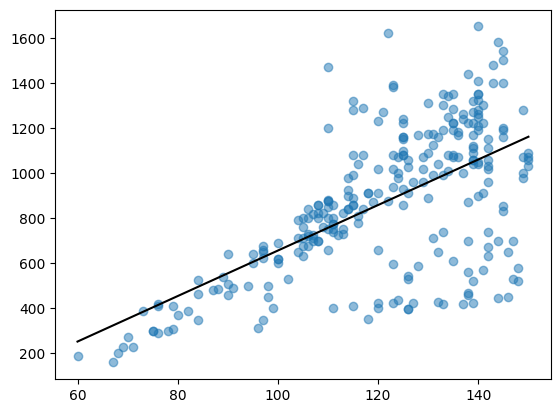

In [33]:
fig, ax = plt.subplots()

ax.scatter(x = juveniles_weight_hindft['hindft'],
           y = juveniles_weight_hindft['weight'],
           alpha =0.5)

# Define parameter of the regression line
x_start = juveniles_weight_hindft['hindft'].min()
x_end = juveniles_weight_hindft['hindft'].max()

# Plot the line
ax.plot([x_start, x_end],
        [slope*x_start + intercept, slope*x_end + intercept],
        color = 'black')

:::{.callout-tip}
# Exercise
Answer the following questions:

a. Does it make sense to interpret the $x$-axis intercept as an estimated measurement of weight?

b. What is the estimated change in weight for each millimiter increase in hind foot length?

c. Does a linear model of weight with respect to hind foot length account completely for the change in the dependent variable? What other variables could be worth exploring to model the weight?

d. How would you use the linear model to estimate the weight of a juvenile hare with hind foot length of 90 mm?
:::

<!--
:::{.callout-tip}
# Exercise 2

This would be an exercise about doing linear regression while grouping by sex
:::
-->

a. No, the x-intercept is negative which doesn't make sense in real world context
b. 10 g per mm increase because of the slope
c. No. Other variables such as ecosystems, males versus females, etc. Our R^2 is far from 1 therefore it is not necessarily a good fit. 
d. Plug in the model.

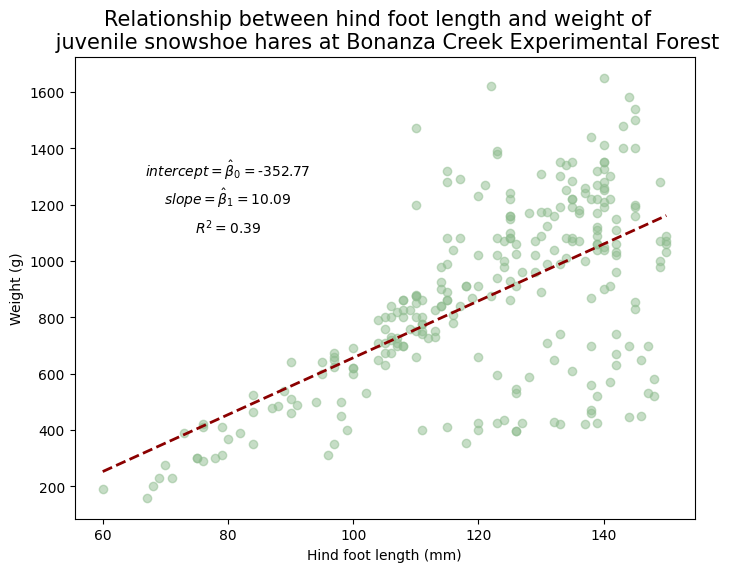

In [34]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(x=juveniles_weight_hindft['hindft'], 
           y=juveniles_weight_hindft['weight'], 
           alpha=0.5,
           color='#8FBC8F')

# Define parameters of the regression line
x_start = juveniles_weight_hindft['hindft'].min()
x_end = juveniles_weight_hindft['hindft'].max()

# Plot the line
ax.plot([x_start, x_end], 
        [slope*x_start + intercept, slope*x_end + intercept],
        color="darkred", 
        lw=2, 
        linestyle="--")

# Add the parameters
beta0 = r'$intercept = \hat\beta_0 =$'+ str(round(intercept,2))
ax.text(80, 1300, beta0, fontsize=10, horizontalalignment='center')

beta1 = r'$slope = \hat\beta_1 =$' + str(round(slope,2))
ax.text(80, 1200, beta1, fontsize=10, horizontalalignment='center')

r_squared = r'$R^2 =$' + str(round(R_sq,2))
ax.text(80, 1100, r_squared, fontsize=10, horizontalalignment='center')        

# Add a title and axis label
ax.set_title('Relationship between hind foot length and weight of  \n juvenile snowshoe hares at Bonanza Creek Experimental Forest',
             {'fontsize':15})
ax.set_xlabel('Hind foot length (mm)')
ax.set_ylabel('Weight (g)')

# Show the plot
plt.show()